# 1. Import basic libraries

In [1]:
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Conv3D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input
import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import matplotlib.pyplot as plt
import random
import numpy as np
from glob import glob
import re
import joblib
from PIL import Image
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

In [2]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    # Configure TensorFlow for deterministic operations
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
    # Configure GPU (if available)
    if tf.config.list_physical_devices('GPU'):
        print("Setting GPU determinism...")
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        
        # Use the following for TensorFlow 2.x
        tf.config.experimental.enable_op_determinism()
set_seeds(42)

pd.set_option('future.no_silent_downcasting', True)

Setting GPU determinism...


# 2. Configuration

In [3]:
class Config:
    MONTHS = ['2019-04', '2019-10', '2020-04', '2020-10']
    FOLDS = range(1, 6)
    SELECTED_FEATURES = [
        'ROW', 'COL'
    ]
    TARGET = 'AWS'
    CSI_THRESHOLD = 0.01
    OPTUNA_TRIALS = 50
    RANDOM_STATE = 42
    N_JOBS = -1
    BASE_DATA_PATH = Path('/kaggle/input/ai-dataimputedataset-k-fold')
    CACHE_DIR = Path('./cachedir')
    OUTPUT_DIR = Path('/kaggle/working')
    METRICS = ['RMSE', 'Pearson R', 'Bias', 'CSI']
    SAVE_PREDICTIONS = True
    SAVE_VALIDATION_PREDICTIONS = False
    LAG_STEPS = [1, 2, 3]
    WINDOW_SIZES = [3, 6]
    USE_LAG_FEATURES = True
    IMG_SHAPE = (90,250,1)
    CUR_YEAR = 2020
    CUR_MONTH = 10
    N_PAST = 6 
    N_FUTURE = 3
    data_dir = "/kaggle/input/dataai/DATA_SV/Precipitation/AWS"
    N_FOLDS = 4
# Set up caching
memory = joblib.Memory(location=Config.CACHE_DIR, verbose=0)

# 3. Utility functions

In [4]:
def compute_csi(y_true, y_pred, threshold, mask):
    print(mask.shape)  # Debugging: Print the shape of the mask
    print(y_true.shape)  # Debugging: Print the shape of y_true

    # Expand mask to match the spatial dimensions of y_true and y_pred
    mask_expanded = mask[np.newaxis, np.newaxis, :, :, np.newaxis]  # Shape: (1, 1, 90, 250, 1)

    # Repeat the mask along the batch and timestep dimensions
    mask_expanded = np.tile(mask_expanded, (y_true.shape[0], y_true.shape[1], 1, 1, 1))  # Shape: (batch_size, timesteps, 90, 250, 1)

    # Apply the mask to y_true and y_pred
    y_true_masked = y_true[mask_expanded]
    y_pred_masked = y_pred[mask_expanded]

    # Check if there are valid pixels to compute CSI
    if len(y_true_masked) == 0 or len(y_pred_masked) == 0:
        raise ValueError("No valid data points available for the specified mask.")

    # Classify events based on the threshold
    y_true_event = (y_true_masked >= threshold)  # Convert to boolean
    y_pred_event = (y_pred_masked >= threshold)  # Convert to boolean

    # Calculate true positives, false positives, and false negatives
    tp = np.sum(y_true_event & y_pred_event)
    fp = np.sum(~y_true_event & y_pred_event)
    fn = np.sum(y_true_event & ~y_pred_event)

    # Compute CSI
    denom = tp + fp + fn
    csi = tp / denom if denom != 0 else 0.0

    return csi


csv_file = '/kaggle/input/rain-precipitation-station/filter_merged_data/merged_2019-04.csv'
df = pd.read_csv(csv_file)
unique_coords = df[['row', 'col']].drop_duplicates().values

def create_mask(shape, coords):
    mask = np.zeros(shape, dtype=bool)
    for row, col in coords:
        if 0 <= row < shape[0] and 0 <= col < shape[1]:
            mask[row, col] = True
    return mask

image_shape = (90, 250)
mask = create_mask(image_shape, unique_coords)
def calculate_metrics_with_mask(y_true, y_pred, mask):
    mask_expanded = mask[np.newaxis, np.newaxis, :, :, np.newaxis]  # Shape: (1, 1, 90, 250, 1)
    mask_expanded = np.tile(mask_expanded, (y_true.shape[0], y_true.shape[1], 1, 1, 1))  # Shape: (142, 3, 90, 250, 1)
    print(mask_expanded.shape)
    print(y_true.shape)
    y_true_masked = y_true[mask_expanded]
    y_pred_masked = y_pred[mask_expanded]
    
    if len(y_true_masked) == 0 or len(y_pred_masked) == 0:
        raise ValueError("No valid data points available for the specified coordinates.")
    
    rmse = np.sqrt(mean_squared_error(y_true_masked, y_pred_masked))
    bias = np.mean(y_pred_masked - y_true_masked)
    r, _ = pearsonr(y_true_masked, y_pred_masked) if len(y_true_masked) > 1 else (0, 1)
    
    return {
        'RMSE': rmse,
        'Bias': bias,
        'R': r
    }

def calculate_metrics(y_true, y_pred):
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)
    print(y_true_flat)
    # Remove NaN values from both arrays while keeping them aligned
    valid_mask = ~np.isnan(y_true_flat) & ~np.isnan(y_pred_flat)
    y_true_filtered = y_true_flat[valid_mask]
    y_pred_filtered = y_pred_flat[valid_mask]
    # Check if there are enough valid values to calculate metrics
    if len(y_true_filtered) == 0 or len(y_pred_filtered) == 0:
        raise ValueError("No valid data points available after filtering NaN values.")
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true_filtered, y_pred_filtered))
    bias = np.mean(y_pred_filtered - y_true_filtered)
    r, _ = pearsonr(y_true_filtered, y_pred_filtered) if len(y_true_filtered) > 1 else (0, 1)
    
    return {
        'RMSE': rmse,
        'Bias': bias,
        'R': r
    }

In [5]:
!pip install -q pykrige

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 18.0 MB/s eta 0:00:00


In [6]:
from pykrige.ok import OrdinaryKriging
import numpy as np
from PIL import Image
def extract_datetime(filename):
    match = re.search(r'AWS_(\d{14})\.tif', os.path.basename(filename))
    if match:
        date_str = match.group(1)
        return datetime.datetime.strptime(date_str, '%Y%m%d%H%M%S')
    return None

def read_tif(img_path):
    img = Image.open(img_path)
    img_array = np.array(img, dtype=np.float64)  # Convert to float for kriging
    img_array = img_array[..., np.newaxis]  # Add channel dimension if needed

    # Check for missing values (NaN)
    if np.isnan(img_array).any():
        # Get the indices of valid (non-NaN) and missing (NaN) values
        valid_mask = ~np.isnan(img_array)
        missing_mask = np.isnan(img_array)

        # Get the coordinates of valid and missing points
        valid_coords = np.column_stack(np.where(valid_mask))
        missing_coords = np.column_stack(np.where(missing_mask))

        # Get the values of valid points
        valid_values = img_array[valid_mask]

        # Apply Ordinary Kriging
        kriging_model = OrdinaryKriging(
            valid_coords[:, 1],  # x-coordinates
            valid_coords[:, 0],  # y-coordinates
            valid_values,
            variogram_model="linear",  # You can choose other models like 'spherical', 'gaussian', etc.
            verbose=False,
            enable_plotting=False,
        )
        # Predict missing values
        z_pred, _ = kriging_model.execute("points", missing_coords[:, 1], missing_coords[:, 0])

        # Fill in the missing values
        img_array[missing_mask] = z_pred

    return img_array

In [7]:
def create_sequences(file_list, n_past, n_future, stride=1):
    X = []
    y = []

    if len(file_list) < n_past + n_future:
        print("Không đủ file để tạo sequences")
        return np.array(X), np.array(y)
        
    max_idx = len(file_list) - n_past - n_future + 1
    
    for i in range(0, max_idx, stride):
        input_seq = []
        for j in range(i, i + n_past):
            img = read_tif(file_list[j])
            input_seq.append(img)
            
        output_seq = []
        for j in range(i + n_past, i + n_past + n_future):
            img = read_tif(file_list[j])
            output_seq.append(img)
            
        X.append(np.array(input_seq))
        y.append(np.array(output_seq))
    return np.array(X), np.array(y)

# 4. Train, test split and training

In [8]:
month_path = Path(Config.data_dir) / str(Config.CUR_YEAR) / f"{Config.CUR_MONTH:02d}"
all_files = []
day_file_counts = {}

for day in range(1, 31):
    day_str = f"{day:02d}"
    day_path = month_path / day_str
    if not day_path.exists():
        continue  # Skip if day directory doesn't exist
        
    day_file_counts[day_str] = 0

        
    for hour in range(24):
        hour_str = f"{hour:02d}"
        # Format the filename with the timestamp pattern
        timestamp = f"{Config.CUR_YEAR}{Config.CUR_MONTH:02d}{day_str}{hour_str}0000"
        filename = f"AWS_{timestamp}.tif"
        file_path = day_path / filename
        if os.path.exists(file_path):
            all_files.append(str(file_path))
            day_file_counts[day_str] += 1

print(f"Found {len(all_files)} files across {len(day_file_counts)} days")
X, y = create_sequences(all_files, Config.N_PAST, Config.N_FUTURE, stride = 1) 
print(f"Training data shape: {X.shape}")
print(f"Training target shape: {y.shape}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Training data shape: {X_test.shape}")
print(f"Training target shape: {y_test.shape}")

Found 718 files across 30 days
Training data shape: (710, 6, 90, 250, 1)
Training target shape: (710, 3, 90, 250, 1)
Training data shape: (568, 6, 90, 250, 1)
Training target shape: (568, 3, 90, 250, 1)
Training data shape: (142, 6, 90, 250, 1)
Training target shape: (142, 3, 90, 250, 1)


In [9]:
# tscv = TimeSeriesSplit(n_splits=Config.N_FOLDS)

# x_train_folds = []
# y_train_folds = []
# x_val_folds = []
# y_val_folds = []

# for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
#     # Extract training and validation data for this fold
#     x_train_fold = X_train[train_idx]
#     y_train_fold = y_train[train_idx]
#     x_val_fold = X_train[val_idx]
#     y_val_fold = y_train[val_idx]
    
#     # Store the data for this fold
#     x_train_folds.append(x_train_fold)
#     y_train_folds.append(y_train_fold)
#     x_val_folds.append(x_val_fold)
#     y_val_folds.append(y_val_fold)
    
#     print(f"Fold {fold+1}/{Config.N_FOLDS} - Training samples: {len(train_idx)}, Validation samples: {len(val_idx)}")

# 5. Start training

In [10]:
class Hyperparams:
    KERNEL_SIZE = 3
    FILTERS = 32
    LR = 0.001
    BATCH_SIZE = 16
    NUM_EPOCHS = 60
    NUM_MID_LAYERS = 3
    PATIENCE = 20

# TUNING = 1
# fold_to_use = Config.N_FOLDS - 1  
# X_train = x_train_folds[fold_to_use]
# y_train = y_train_folds[fold_to_use]
# X_val = x_val_folds[fold_to_use]
# y_val = y_val_folds[fold_to_use]

X_train = np.nan_to_num(X_train, neginf=0)  # Replaces -inf with 0
y_train = np.nan_to_num(y_train, neginf=0)
# X_val = np.nan_to_num(X_val, neginf=0)  # Replaces -inf with 0
# y_val = np.nan_to_num(y_val, neginf=0)
X_test = np.nan_to_num(X_test, neginf=0)  # Replaces -inf with 0
y_test = np.nan_to_num(y_test, neginf=0)

print(f"Training data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
# print(f"Validation data shape: {X_val.shape}")
# print(f"Validation target shape: {y_val.shape}")

Training data shape: (568, 6, 90, 250, 1)
Training target shape: (568, 3, 90, 250, 1)


In [11]:
sequence_shape = X_train.shape[2:]

model = Sequential([
    Input(shape=(None,*X_train.shape[2:]))
])

for i in range(Hyperparams.NUM_MID_LAYERS):
    model.add(ConvLSTM2D(filters=Hyperparams.FILTERS, 
                    kernel_size=(Hyperparams.KERNEL_SIZE, Hyperparams.KERNEL_SIZE),          
                    padding='same',  
                    activation='relu', 
                    return_sequences=True))
    model.add(BatchNormalization())

model.add(Conv3D(filters=1, 
                 kernel_size=(4, 3, 3),  # Larger kernel in time dimension
                 strides=(2, 1, 1),      # Stride of 2 in time dimension
                 activation='sigmoid', 
                 padding='same'))
# Fix the learning rate parameter name
model.compile(optimizer=Adam(learning_rate=Hyperparams.LR), loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, None, 90, 250, 32)   │          38,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, None, 90, 250, 32)   │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, None, 90, 250, 32)   │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, None, 90, 250, 32)   │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, None, 90, 250, 32)   │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, None, 90, 250, 32)   │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, None, 90, 250, 1)    │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 187,393 (732.00 KB)

 Trainable params: 187,201 (731.25 KB)

 Non-trainable params: 192 (768.00 B)

In [12]:
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=Hyperparams.PATIENCE, restore_best_weights=True),
#     ModelCheckpoint('best_convlstm_rain_model.keras', save_best_only=True)
# ]
checkpoint_callback = ModelCheckpoint(
    filepath='ConvLSTM.keras', 
    monitor='val_loss',        
    mode='min',
    save_best_only=True, 
    verbose=1
)
    
print("Training model...")
history = model.fit(
    X_train, y_train,
    epochs=Hyperparams.NUM_EPOCHS,
    batch_size=Hyperparams.BATCH_SIZE,
    validation_split=0.2,
    callbacks=[checkpoint_callback]
)

Training model...
Epoch 1/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - loss: 0.2572
Epoch 1: val_loss improved from inf to 0.23492, saving model to ConvLSTM.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.2549 - val_loss: 0.2349
Epoch 2/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - loss: 0.1362
Epoch 2: val_loss improved from 0.23492 to 0.14586, saving model to ConvLSTM.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 870ms/step - loss: 0.1360 - val_loss: 0.1459
Epoch 3/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - loss: 0.1302
Epoch 3: val_loss improved from 0.14586 to 0.12326, saving model to ConvLSTM.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 872ms/step - loss: 0.1301 - val_loss: 0.1233
Epoch 4/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - loss: 0.1277
Epoch 4: val_loss improved from 0.12326 to 0.11819, saving model to ConvLSTM.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 872ms/step - loss: 0.1276 - val_loss: 0.1182
Epoch 5/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - loss: 0.1268
Epoch 5: val_loss 

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 554ms/step
(142, 3, 90, 250, 1)
(142, 3, 90, 250, 1)
(90, 250)
(142, 3, 90, 250, 1)
CSI 0.5059027777777778
Metrics on 142 future images: {'RMSE': 2.9455087101265405, 'Bias': 0.4778338718479188, 'R': 0.3944411429028435}


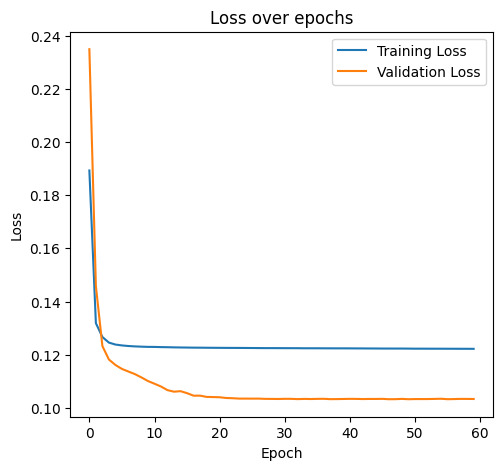

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
threshold = 0.01
predictions = model.predict(X_test)
metrics = calculate_metrics_with_mask(predictions, y_test, mask)
metrics_csi = compute_csi(predictions, y_test, threshold, mask)
print("CSI", metrics_csi)
print(f"Metrics on {len(y_test)} future images:", metrics)

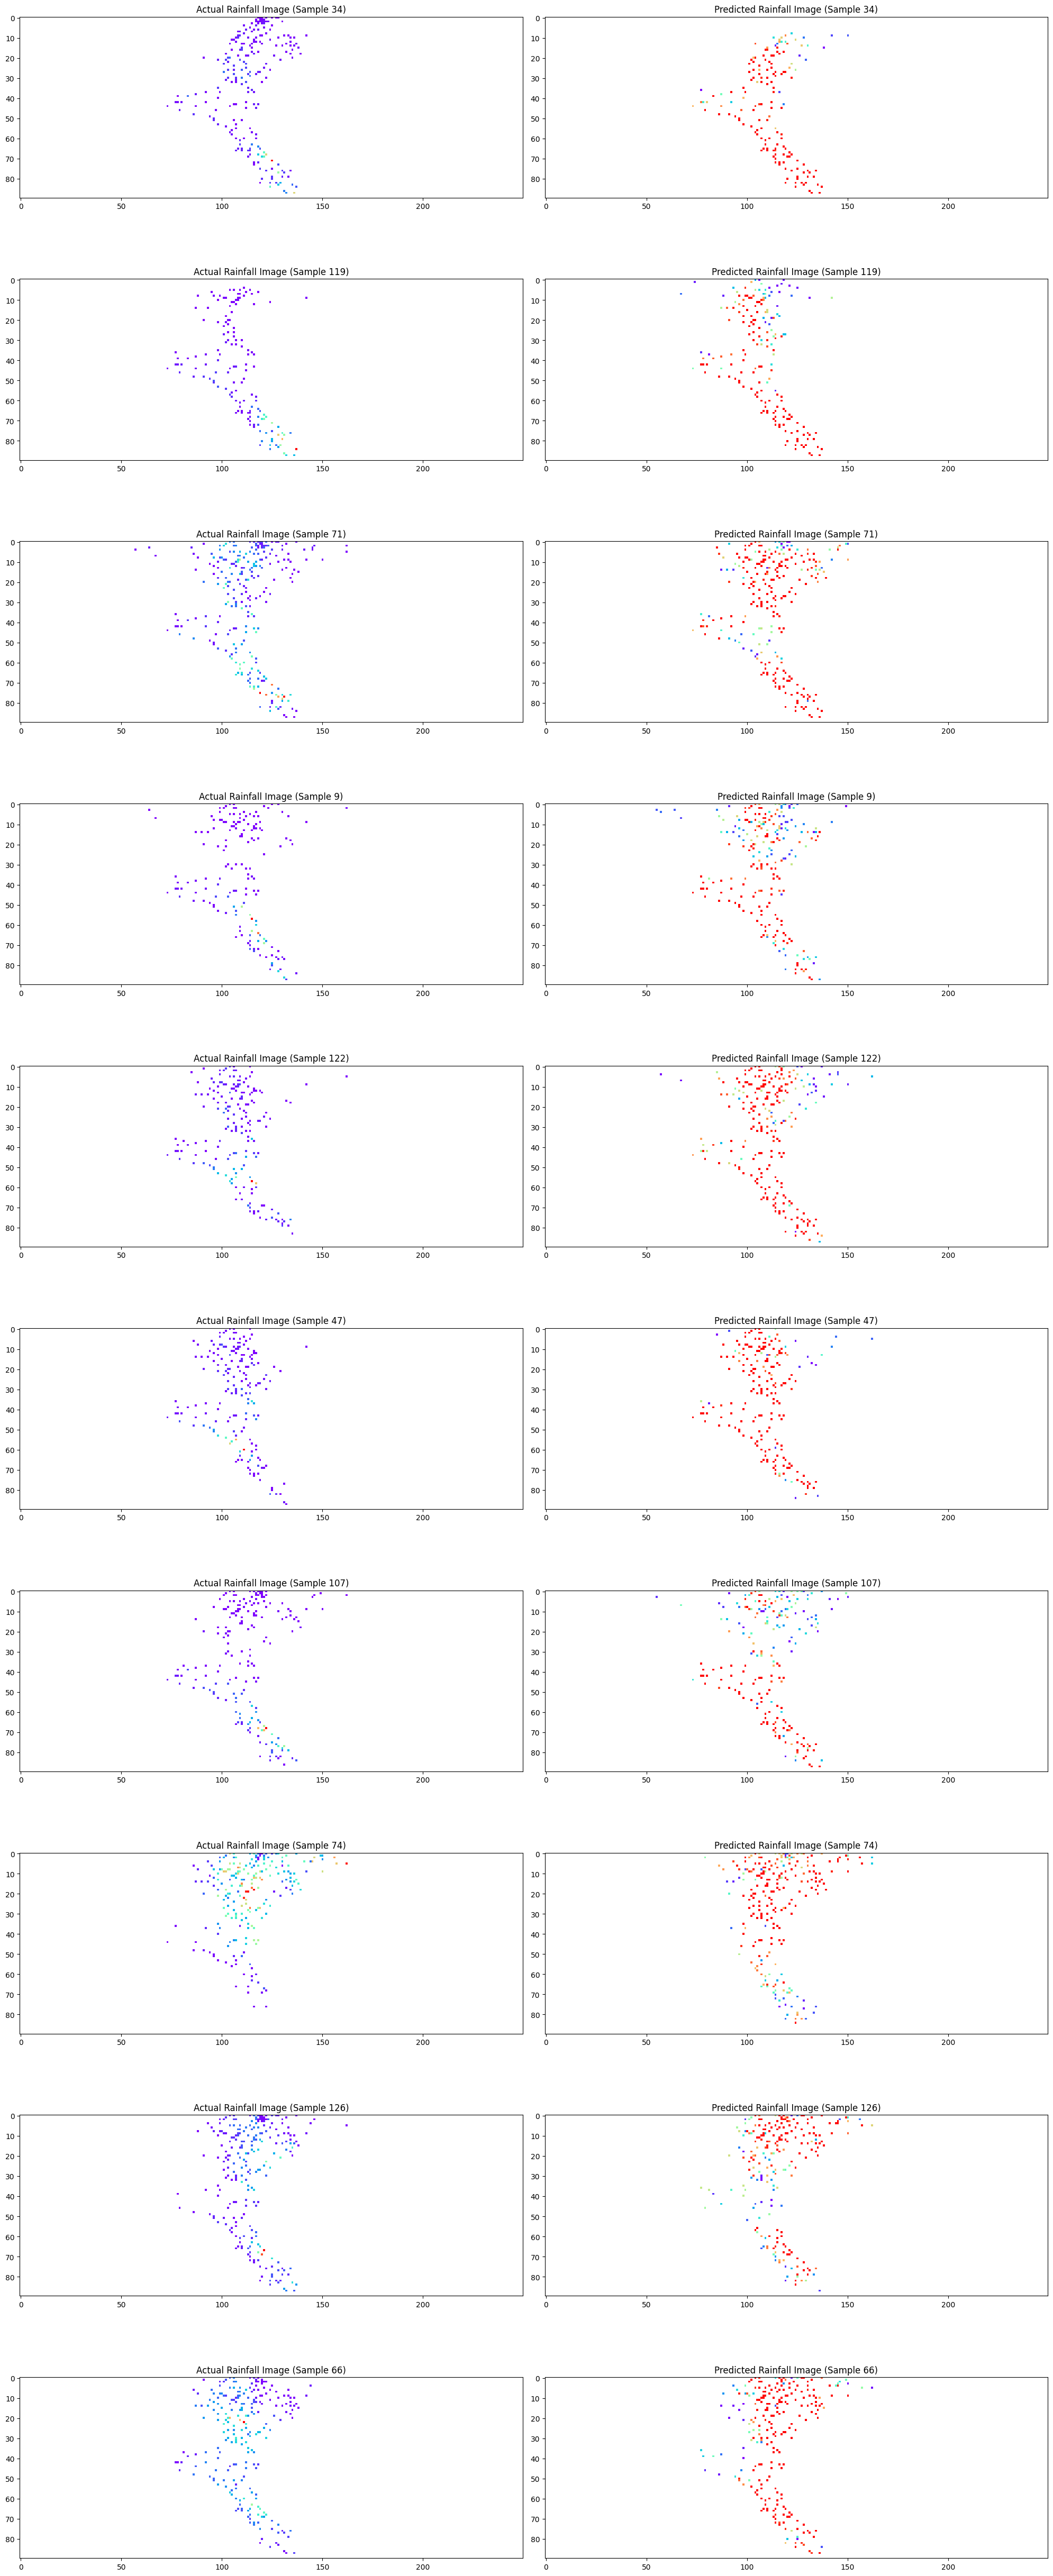

In [14]:
import numpy.ma as ma

# Number of examples to visualize
num_examples = 10  

# Calculate total rainfall for each sample in y_test
total_rainfall = [np.sum(sample) for sample in y_test]
top_indices = np.argsort(total_rainfall)[-num_examples:]  # Indices of samples with the most rain

plt.figure(figsize=(20, 5 * num_examples))

for i, idx in enumerate(top_indices):
    # Plot actual image
    actual_image = y_test[idx][0].reshape(90, 250)  # Adjust indexing if needed
    masked_actual_image = ma.masked_where(actual_image <= 0.1, actual_image)
    cmap = plt.cm.rainbow
    cmap.set_bad(color='white')
    plt.subplot(num_examples, 2, i * 2 + 1)
    plt.imshow(masked_actual_image, cmap=cmap)  # Actual
    plt.title(f'Actual Rainfall Image (Sample {idx})')
    plt.axis('on')

    # Plot predicted image
    predicted_image = predictions[idx][0].reshape(90, 250)  # Adjust indexing if needed
    masked_predicted_image = ma.masked_where(predicted_image <= 0.1, predicted_image)
    cmap = plt.cm.rainbow
    cmap.set_bad(color='white')
    plt.subplot(num_examples, 2, i * 2 + 2)
    plt.imshow(masked_predicted_image, cmap=cmap)  # Prediction
    plt.title(f'Predicted Rainfall Image (Sample {idx})')
    plt.axis('on')

    # print(actual_image)

plt.tight_layout()
plt.show()